(sec:q-learning)=
# Q学習

ここまでで扱った多腕バンディット問題は、取れる行動の種類が少なく、また、問題の状態が変化しない、すなわち、いつスロットを回しても、各アームの当たり確率は変化しない、という特徴があった。しかし、実際の問題は取れるべき行動の種類が多く(場合によっては連続変数)、また、ある時刻で取った行動により、行動を行う対象の状態が変化するのが一般的である。

このような状況において用いられる強化学習の手法に**Q学習**がある。Q学習のQとは**行動価値関数**を表すQ値のQであり、とある**状態**$s$ (stateのs)において取った**行動**$a$ (actionのa)の価値を関数として、$Q(s, a)$のように表す。

このようなQ値を学習する方法はQ学習以外にも**SARSA**(state-action-reward-state-action)と呼ばれる方法もあるが、本節ではQ学習に絞って説明する。

In [1]:
"""
下準備のコード
"""

import random

import numpy as np
import seaborn as sns
import matplotlib
import IPython.display as display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.animation import ArtistAnimation

# 乱数のシードを固定
random.seed(31415)
np.random.seed(31415)


# グラフの設定
matplotlib.rcParams["figure.dpi"] = 150
sns.set(style="white", palette="colorblind")

## 背景

Q学習で扱う対象は**Markov決定過程**と呼ばれる状態遷移のモデルである。

Markov決定過程をかみ砕いて言えば、その時々で取った行動により次の状態が変化するが、それより過去に取った行動がその状態の変化に影響を与えることはない、という性質 (この性質を**Markov性**と呼ぶ)を満たす状態遷移のモデルである。

Markov性を満たす状態遷移であれば、とある状態$s$において、行動を$a$取ったときに、別の状態$s'$に移る確率は$s, a$だけに関する事後確率として$P(s' | s, a)$のように書ける。

Q学習では、この事後分布$P(s' | s, a)$を用いて、行動評価関数$Q(s, a)$が以下のBellmanの最適性公式を満たすと仮定する。

$$
Q(s, a) = R(s, a) + \gamma \sum_{a' \in \mathcal{A}} P(s' | s, a) Q(s', a')
$$ (eq:bellman-equation)

この式において$\gamma$は**割引因子** (discount factor)と呼ばれる値で、$0 < \gamma < 1$であり、$R(s, a)$は状態$s$において行動$a$を取ったときに即座に得られる報酬を表す。

{eq}`eq:bellman-equation`は、**最適な行動価値関数が、その時、即座に得られる報酬$R(s, a)$と未来の行動から得られる報酬に一定の減衰を加えたものの和として表せる**ことを示している。

一方、多くの状態遷移のモデルでは、状態遷移は確率的なものではなく、行動$a$の結果として**一意に次の状態が決まる**ことが多い。そこで$P(s' | s, a) = 1$と仮定する。さらに、仮に理想的なQ関数が求まっているのであれば、$s'$において行動価値が最大になる行動$a'$をQ関数から決定できるので、$a'$は行動価値が最大になるものであると仮定する。

これら2つの仮定により、{eq}`eq:bellman-equation`は、以下の形で書き直せる。

$$
Q(s, a) = R(s, a) + \gamma \max_{a' \in \mathcal{A}} Q(s', a')
$$ (eq:bellman-equation-2)

Q学習は、{eq}`eq:bellman-equation-2`を満たすような$Q(s, a)$を強化学習の枠組みによって求めるものである。

## アルゴリズム

Q学習は、実際の環境において、適当な行動を取ったときに得られる報酬と状態遷移から、{eq}`eq:bellman-equation-2`の両辺の差が小さくなるように$Q(s, a)$の値を更新する。

典型的なQ学習の実装では、$s$と$a$を離散化して、$Q(s, a)$を二次元配列として扱う。このような離散化されたQ関数を**Qテーブル**と呼ぶ。

Qテーブルの更新は現在の$Q(s, a)$の値 (学習途中は必ずしも{eq}`eq:bellman-equation-2`を満たしていないことに注意)を{eq}`eq:bellman-equation-2`の右辺に近づくように更新する。

具体的には、学習率$0 < \alpha < 1$を用いて、以下の式で$Q(s, a)$を更新する。

$$
Q_{\rm new}(s, a) = (1 - \alpha) Q(s, a) + \alpha \left[ R(s, a) + \gamma \max_{a'} Q(s', a') \right]
$$

また、この式は以下の形で書き直すことができる。

$$
Q_{\rm new}(s, a) = Q(s,a ) + \alpha \left[ R(s, a) + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$ (eq:q-update)

{eq}`eq:q-update`の右辺の

$$
R(s, a) + \gamma \max_{a'} Q(s', a') - Q(s, a)
$$

は、**TD誤差** (temporal difference error)と呼ばれ、Q学習はこのTD誤差を最小化する問題であると言い換えることができる。

## 倒立振子のバランシング

Q学習を実際に試すために、比較的単純な倒立振子のバランスを取るゲームについて考える。倒立振子のシミュレータは[Gymnasium](https://gymnasium.farama.org/)というライブラリ(旧名: OpenAI Gym)から簡単に使用することができる。

モジュール`gymnasium`をインポート後 (`gym`とエイリアスをつける)、`gym.make`関数を用いてゲーム環境`env`を作成してみる。

`gym.make`関数に倒立振子のゲーム環境である`CartPole-v1`を指定し、`render_mode`パラメータに`rbg_array`を指定する。

このように`render_mode`を指定しておくと、`env.render`関数によって画面の情報をNumPyの配列として得ることができるので、Matplotlibを用いて、初期状態を描画してみる。

In [2]:
import gymnasium as gym

# ゲーム環境の作成
env = gym.make("CartPole-v1", render_mode="rgb_array")

# ゲーム環境のリセット
obsrv = env.reset(seed=31415)

# 現在の状態をRGB画像として取得する
img = env.render()

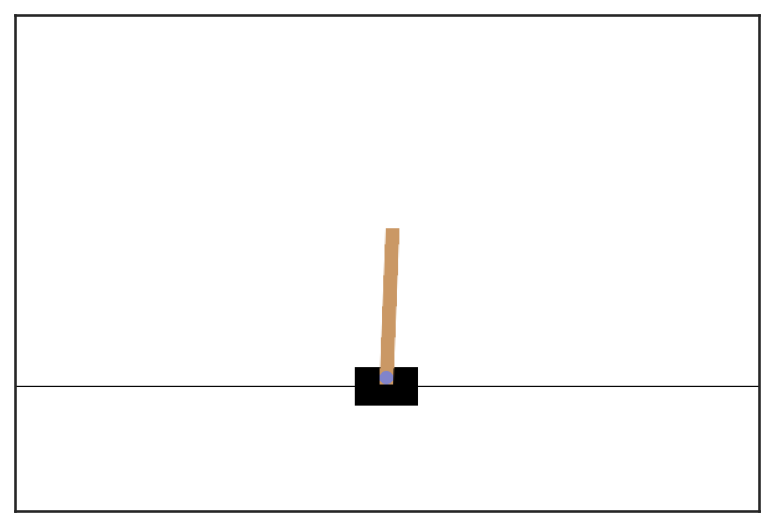

In [3]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.set(xticks=[], yticks=[])
plt.show()

このように、CartPoleは台車 (cart)の上に倒立振子 (pole)が取り付けられたものを制御して、できる限り長い時間、振子が倒れないようにバランスを取るゲームである。

倒立振子は、その状態を表すいくつかのパラメータを持っており、それが`reset`関数の戻り値として取得される`obsrv`の中に格納されている。

`obsrv`は`tuple`型の変数になっていて、CartPole環境の場合には**第1要素に状態を表す変数が入っている**。

In [4]:
# 現在の状態変数を確認
print(obsrv[0])

[-3.1067048e-05 -3.8479745e-02  3.6217723e-02  3.3740070e-02]


CartPole環境の場合は、4つの浮動小数が格納されており、先頭から、
- 台車の水平位置
- 台車の速度
- 振子の角度
- 振子の角速度
をそれぞれ表している。

また、それぞれの値が取る範囲は以下のようになっている [[参考URL]](https://gymnasium.farama.org/environments/classic_control/cart_pole/)。

|Num|Observation|Min|Max|
|---|---|---|---|
| 0 | 台車の位置 | -4.8 | +4.8 |
| 1 | 台車の速度 | -Inf | +Inf |
| 2 | 振子の角度 | -24° | +24° |
| 3 | 振子の角速度 | -Inf | +Inf |

この値は、`env`の`observation_space`フィールドで確認することができる。

CartPole環境の場合には`observation_space`は`Box`という型で表されていて、`low`、`high`というフィールドにパラメータの最小値、最大値が格納されている。

In [5]:
print("Lower bound:", env.observation_space.low)
print("Upper bound:", env.observation_space.high)

Lower bound: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Upper bound: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


Gyminasiumのゲーム環境には、この他にも多数の関数が用意されており、それを強化学習に用いることができる。

まずは、その挙動を理解するために、ランダムに行動を選んだ場合にどのような動きになるのかを確認してみよう。

ランダムな行動選択には、`env.action_space.sample()`を使うことができる。CartPole環境の場合には`env.action_space.n`に格納されているとおり、取り得る行動は **0: 左に移動**, **1: 右に移動** の2つだけなので、`sample`関数はこのうちの一方をランダムに返してくる。

In [6]:
# ランダムに5回行動選択をしてみる
for i in range(5):
    print(env.action_space.sample())

0
1
1
1
0


選んだ行動をとって状態を更新するには`env.step`関数を用いる。`step`関数の引数に行動を表す整数を与えることで状態が更新される。

`step`関数もまた`reset`関数と同様に`tuple`型の変数を返してくる。ここには`reset`関数の時よりも多くの情報が含まれていて、

- **第1要素:** 現在の状態を表すパラメータ (上記の`obsrv`と同様)
- **第3要素:** 行動により直接得られた報酬
- **第4要素:** エピソードが終了したかどうか (ゲームオーバーになったかどうか)
- **第2要素:** 行動を表すパラメータが範囲外に外れたかどうか (今回は使用しない)
- **第5要素:** その他の追加情報 (今回は使用しない)

のような構成となっている。

In [7]:
obsrv, reward, done, _, _ = env.step(0)
print("Observation:", obsrv)
print("Reward:", reward)
print("Finished?:", done)

Observation: [-0.00080066 -0.23410185  0.03689252  0.3376265 ]
Reward: 1.0
Finished?: False


### ランダムな行動選択

これらを用いてランダムに行動選択をし、その時々の状態を画像として格納する。

In [8]:
# ゲーム環境のリセット
obsrv, _ = env.reset()
frames = []

# ゲームループ
while True:
    # 現在の画面を画像として保存
    img = env.render()
    frames.append(img)

    # ランダムに行動選択
    a = env.action_space.sample()

    # 状態を更新する
    obsrv, reward, done, _, _ = env.step(a)

    # もしゲームが終了していたらループを抜ける
    if done:
        break

In [9]:
# アニメーションの描画
fig, ax = plt.subplots(dpi=100)
ax.set(xticks=[], yticks=[])

# 各フレームの描画
draw = []
for i, f in enumerate(frames):
    ims = plt.imshow(f)
    txt = plt.text(20, 30, f"frame #{i+1:d}")
    draw.append([ims, txt])

# アニメーションの作成
ani = ArtistAnimation(fig, draw, interval=100, blit=True)
html = display.HTML(ani.to_html5_video())
display.display(html)

# Matplotlibのウィンドウを閉じる
plt.close()

このようにランダムに行動した場合には、途中で棒の傾きが一定以上になってしまい、エピソードが終了していることが分かる。以下では、Q学習によって行動評価関数を最適化し、より長い時間、倒立状態を保てるようにしてみよう。

この時、各変数は連続的な値を取るため、Q値のテーブルを学習するためには、値を離散化して置く必要がある。これにはNumPyのdigitize関数が使える。

In [27]:
from functools import reduce

N_DIGITS = 8
N_INPUTS = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n

lower = env.observation_space.low
upper = env.observation_space.high
lower[1], upper[1] = -5.0, 5.0  # 速度の範囲を修正
lower[3], upper[3] = -0.5 * np.pi, 0.5 * np.pi  # 角速度の範囲を修正

bins = np.transpose(np.linspace(lower, upper, N_DIGITS))
obsrv, _ = env.reset()

In [28]:
# Q値テーブルの初期化 (乱数による初期化)
q_table = np.random.random(size=(N_DIGITS**N_INPUTS, env.action_space.n))

In [29]:
# ランダムに行動する
a = env.action_space.sample()
s1 = env.step(a)

In [30]:
# 一番価値が高く見積もられている行動をとる
digits = [np.digitize(x, bin) for x, bin in zip(obsrv, bins)]
s0 = reduce(lambda a, b: a + b * 10, digits)
a = np.argmax(q_table[s0, :])
s1 = env.step(a)

In [32]:
# Q学習のハイパーパラメータ
alpha = 0.5
gamma = 0.99

# Q値テーブルの初期化
q_table = np.zeros((N_DIGITS**N_INPUTS, env.action_space.n))

for epi in tqdm(range(10000)):
    # ゲーム環境のリセット
    obsrv, _ = env.reset()

    # エピソード開始
    while True:
        # 現在の状態に対応する行番号を計算
        digits = [np.digitize(x, bin) for x, bin in zip(obsrv, bins)]
        s0 = reduce(lambda a, b: a + b * 10, digits)

        # ε-greedy法による行動選択
        if np.random.random() < 0.5:
            a = env.action_space.sample()
        else:
            a = np.argmax(q_table[s0, :])

        # 状態の更新
        obsrv, reward, done, _, info = env.step(a)

        # 新たな状態に対する行番号を計算
        digits = [np.digitize(x, bin) for x, bin in zip(obsrv, bins)]
        s1 = reduce(lambda a, b: a + b * 10, digits)

        # Qテーブルの更新
        q0 = q_table[s0, a]
        best_q1 = np.max(q_table[s1, :])
        q_table[s0, a] = (1.0 - alpha) * q0 + alpha * (reward + gamma * best_q1)

        if done:
            break

  0%|          | 0/10000 [00:00<?, ?it/s]

In [33]:
frames = []
obsrv, _ = env.reset()
while True:
    img = env.render()
    frames.append(img)

    # 最もQ値の高い行動を選択
    digits = [np.digitize(x, bin) for x, bin in zip(obsrv, bins)]
    s0 = reduce(lambda a, b: a + b * 10, digits)
    a = np.argmax(q_table[s0, :])

    obsrv, reward, done, _, _ = env.step(a)
    if done:
        break

In [34]:
# アニメーションの描画
fig, ax = plt.subplots(dpi=100)
ax.set(xticks=[], yticks=[])

# 各フレームの描画
draw = []
for i, f in enumerate(frames):
    ims = plt.imshow(f)
    txt = plt.text(20, 30, f"frame #{i+1:d}")
    draw.append([ims, txt])

# アニメーションの作成
ani = ArtistAnimation(fig, draw, interval=100, blit=True)
html = display.HTML(ani.to_html5_video())
display.display(html)

# Matplotlibのウィンドウを閉じる
plt.close()

## 練習問題

- CartPole環境において、$\varepsilon$-greedy法の部分をソフトマックス探索やUCB1値を用いた探索に置き換えて、学習の性能がどのように変化するかを調べよ。
- CartPole環境は1フレームごとに報酬として常に1を返してくるが、この値を画面中央にCartがある場合に高い値になるように更新することで、できる限り画面の内側で振子を保つように学習方法を変更せよ。